# Previsão de PLD

Passos:

1. Auto correlação
1. Componente Cíclica, Sazonal e Tendência
1. Estacionariedade
1. Modelagem
    - Médias móveis
    - suavização exponencial
    - ARMA/ARIMA/SARIMA e a coisa toda
1. Métricas de Erro
    - MAE
    - MRSE
    - MAPE

**Valores mínimos e máximos de PLD (Resolução Normativa ANEEL nº 858/19)**

<!-- 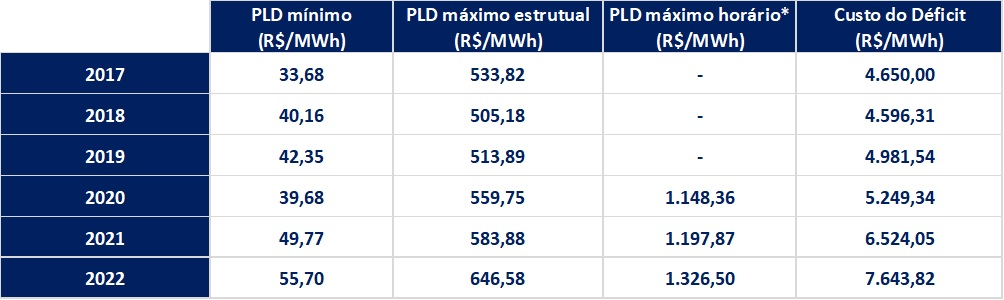 -->




| Ano  | PLD mínimo (R\$/MWh) | PLD máximo estrutual (R\$/MWh) | PLD máximo horário* (R\$/MWh) | Custo do Déficit (R\$/MWh) | 
|------|----------------------|--------------------------------|-------------------------------|----------------------------| 
| 2017 | 33,68                | 533,82                         | -                             | 4.650,00                   | 
| 2018 | 40,16                | 505,18                         | -                             | 4.596,31                   | 
| 2019 | 42,35                | 513,89                         | -                             | 4.981,54                   | 
| 2020 | 39,68                | 559,75                         | 1.148,36                      | 5.249,34                   | 
| 2021 | 49,77                | 583,88                         | 1.197,87                      | 6.524,05                   | 
| 2022 | 55,70                | 646,58                         | 1.326,50                      | 7.643,82                   | 


<center>
    Fonte: <a href="https://www.ccee.org.br/web/guest/precos/conceitos-precos" target="_blank">https://www.ccee.org.br/web/guest/precos/conceitos-precos</a>
</center>


## Import e leitura dos dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
DATAPATH = '../data/raw/pld-horario.csv'

data = pd.read_csv(DATAPATH, index_col='Data_Hora_Referencia', parse_dates=True)
pld_mensal = pd.read_csv('../data/raw/pld-mensal.csv', index_col='mes', parse_dates=True).drop(columns=['norte', 'nordeste', 'sul'])
data.head(10)

,NORDESTE,NORTE,SUDESTE,SUL
Data_Hora_Referencia,,,,
2018-04-17 00:00:00,40.16,40.16,40.16,40.16
2018-04-17 01:00:00,40.16,40.16,40.16,40.16
2018-04-17 02:00:00,40.16,40.16,40.16,40.16
2018-04-17 03:00:00,40.16,40.16,40.16,40.16
2018-04-17 04:00:00,40.16,40.16,40.16,40.16
2018-04-17 05:00:00,40.16,40.16,40.16,40.16
2018-04-17 06:00:00,40.16,40.16,40.16,40.16
2018-04-17 07:00:00,40.16,40.16,40.16,40.16
2018-04-17 08:00:00,116.88,116.84,116.86,116.86


Vou trabalhar só com o PLD do sudeste, então vou descartar os outros

In [3]:
data = data.drop(columns=[col for col in data.columns if col != 'SUDESTE'])

In [4]:
data.head()

,SUDESTE
Data_Hora_Referencia,
2018-04-17 00:00:00,40.16
2018-04-17 01:00:00,40.16
2018-04-17 02:00:00,40.16
2018-04-17 03:00:00,40.16
2018-04-17 04:00:00,40.16


## EDA

In [5]:
def plot_serie(serie, title):
    plt.figure(figsize=(17, 8))
    plt.plot(serie)
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('PLD')
    plt.grid(False)
    plt.show()

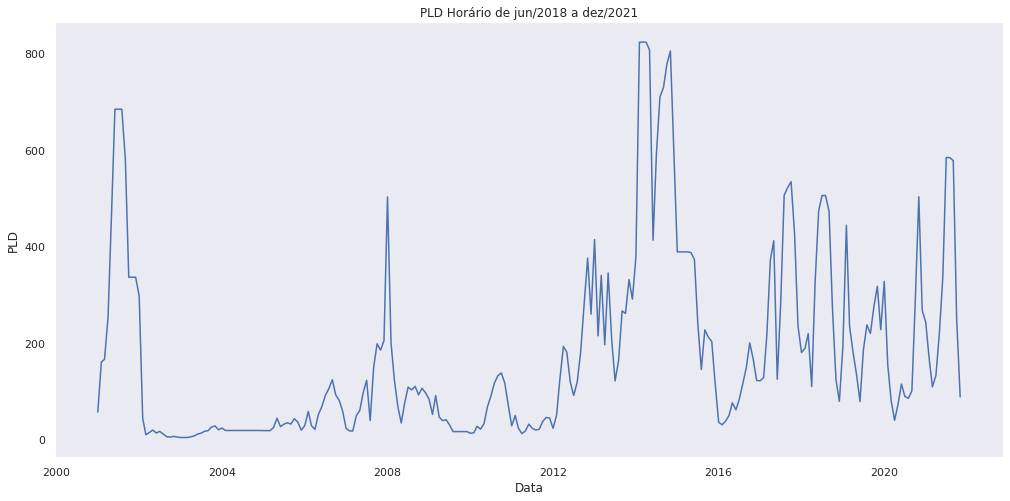

In [6]:
plot_serie(pld_mensal, title='PLD Horário de jun/2018 a dez/2021')

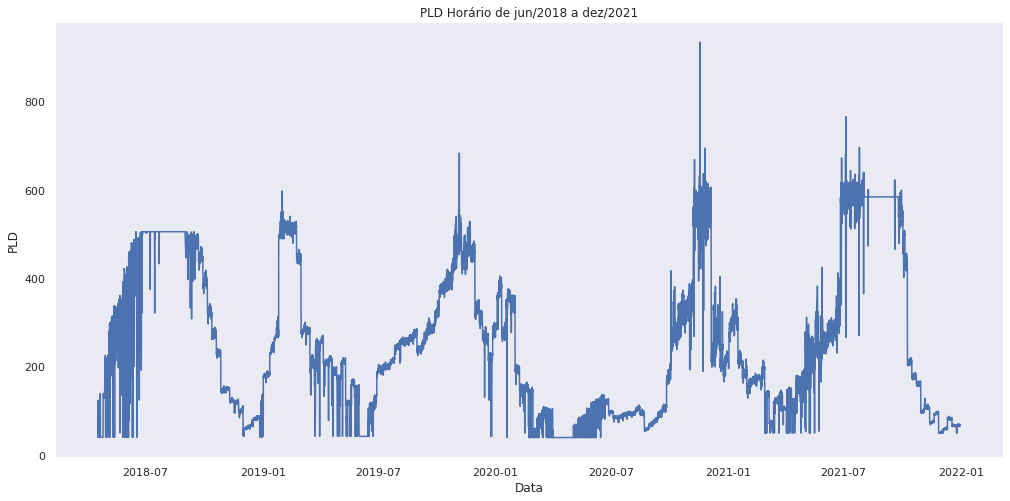

In [7]:
plot_serie(data, title='PLD Horário de jun/2018 a dez/2021')

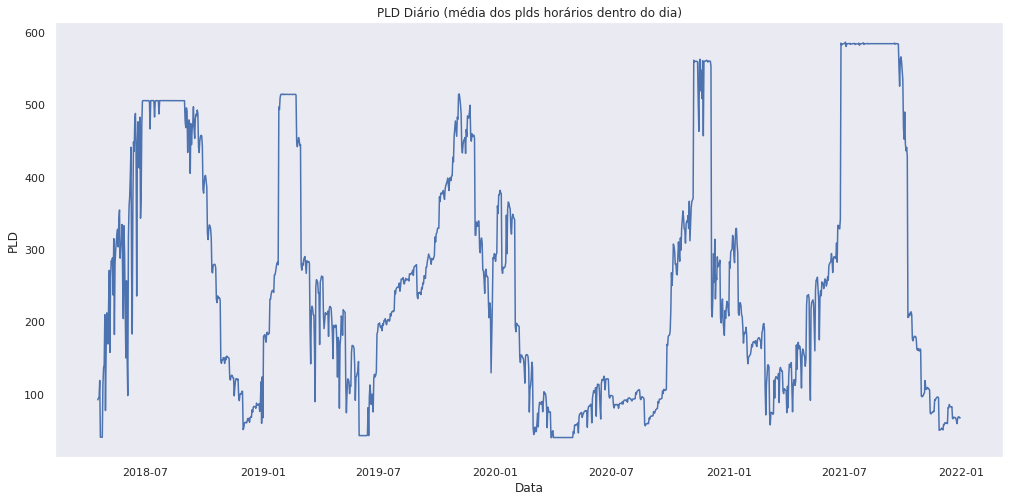

In [8]:
plot_serie(data.resample('D').mean(), title='PLD Diário (média dos plds horários dentro do dia)')

Os valores ficam um pouco "achatados" em algumas partes pois o PLD possui valores mínimos e máximos limitados por resolução da ANEEL (https://www.ccee.org.br/precos/conceitos-precos)

## Suavização

### Média móvel simples

In [9]:
def plot_moving_average(series, window, plot_original=True, plot_intervals=False, scale=1.96, title=None):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))

    title = title if title is not None else f'Média Móvel\n {window = }'
    plt.title(title)
    
    if plot_original:
        plt.plot(series[window:], label='Série Original', alpha=0.7)

    plt.plot(rolling_mean, 'r', label='Média Móvel simples')
        
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    

    plt.legend(loc='best')
    plt.grid(True)
    

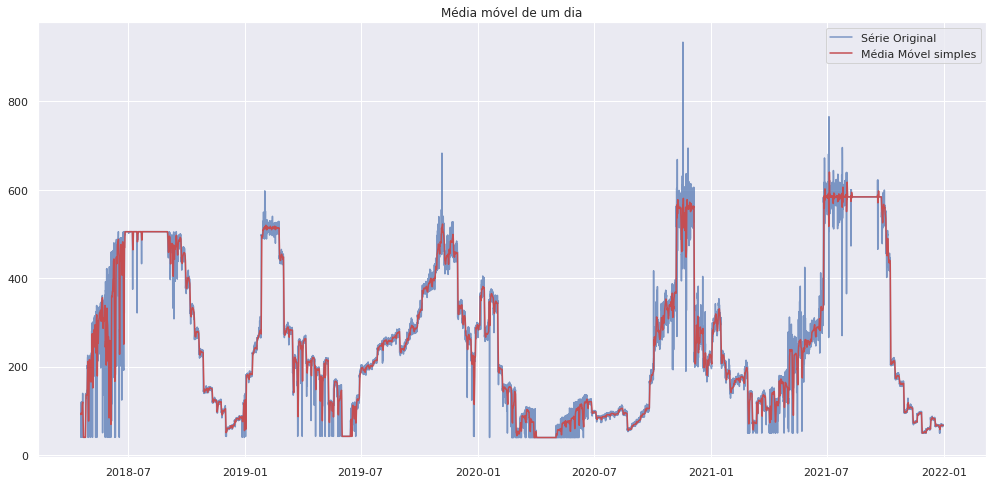

In [10]:
plot_moving_average(data, window=24, plot_intervals=False, title='Média móvel de um dia')

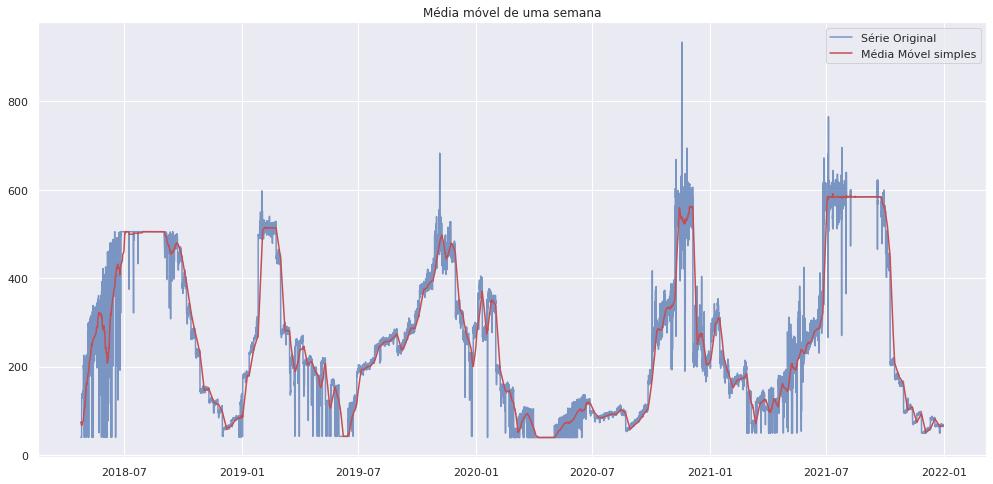

In [11]:
plot_moving_average(data, window=24*7, plot_intervals=False, title='Média móvel de uma semana')

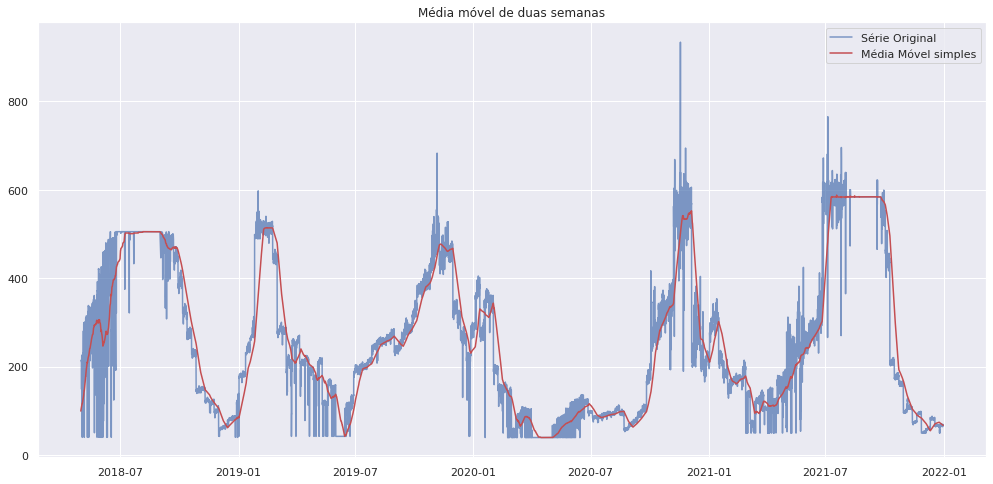

In [12]:
plot_moving_average(data, window=24*14, plot_intervals=False, title='Média móvel de duas semanas')

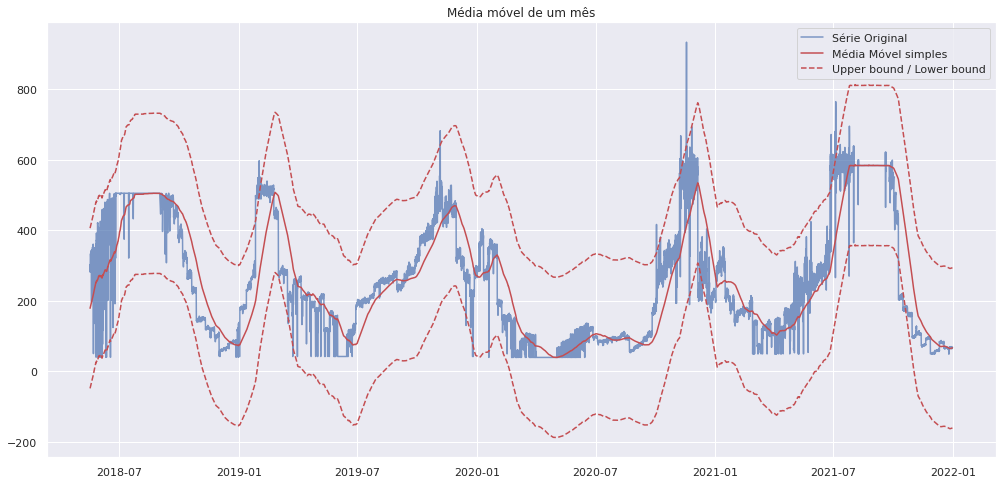

In [13]:
plot_moving_average(data, window=24*30, plot_intervals=True, title='Média móvel de um mês')

É muito difícil observar uma tendência, uma vez que a média móvel é muito próxima a curva original

#### Exponencial




In [14]:
def plot_exponential_smoothing(series, spans, adjust=False):
    plt.figure(figsize=(17, 8))

    plt.plot(series, "c", label = 'Original', alpha=0.5)
    for span in spans:
        # plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        span_value = span['value']
        df_plt = data.ewm(span=span_value, adjust=adjust).mean()

        span_label = span.get('label')
        label = span_label if span_label is not None else f'span = {span_value}'
        plt.plot(df_plt, label=label)
    
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);


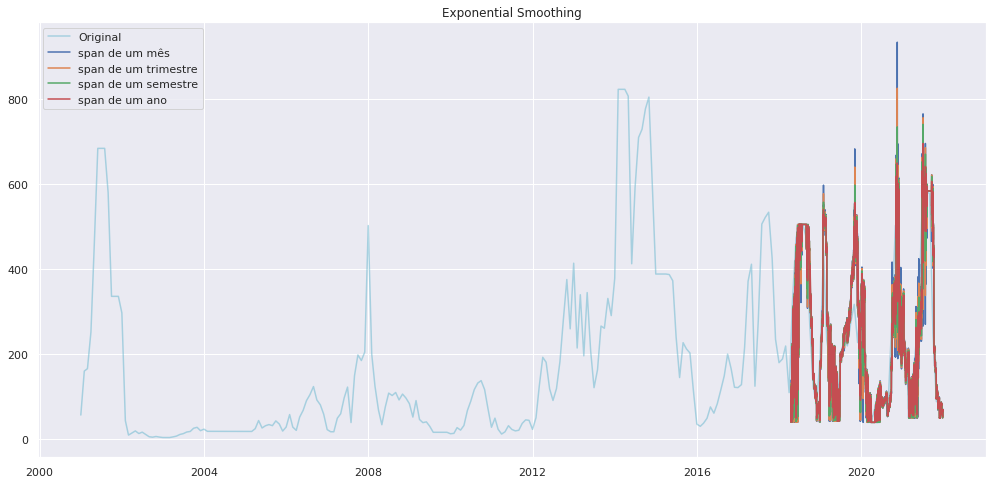

In [15]:
spans = [
    {'label': 'span de um mês', 'value': 1},
    {'label': 'span de um trimestre', 'value': 3},
    {'label': 'span de um semestre', 'value': 6},
    {'label': 'span de um ano', 'value': 12},
]

plot_exponential_smoothing(pld_mensal, spans=spans)

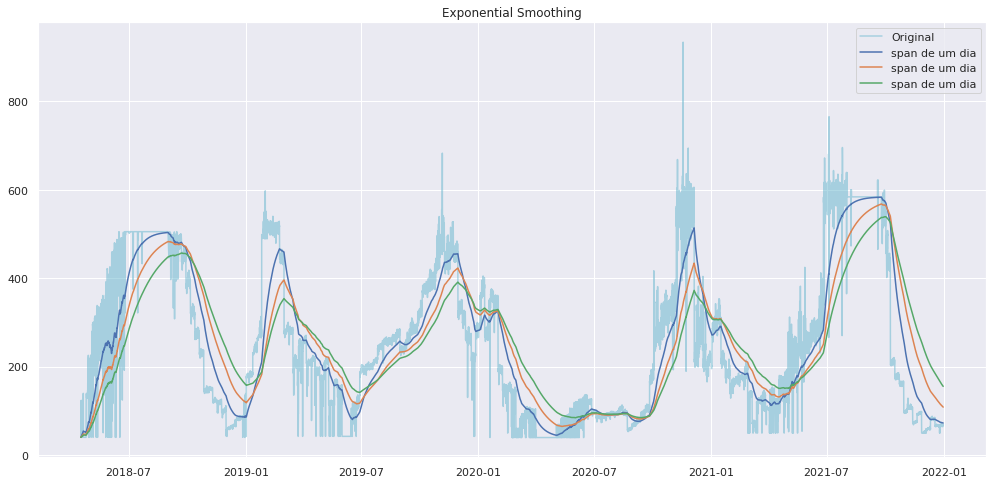

In [16]:
spans = [
    # {'value': 24},
    # {'label': 'span de uma semana', 'value': 24*7},
    {'label': 'span de um dia', 'value': 24 * 30},
    {'label': 'span de um dia', 'value': 24*60},
    {'label': 'span de um dia', 'value': 24 * 90},
]

plot_exponential_smoothing(data, spans=spans)

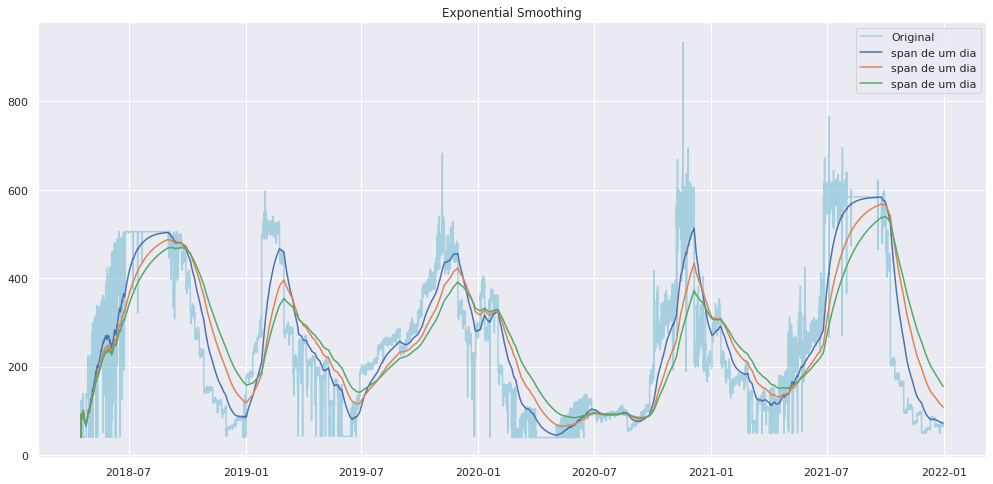

In [17]:
spans = [
    # {'value': 24},
    # {'label': 'span de uma semana', 'value': 24*7},
    {'label': 'span de um dia', 'value': 24 * 30},
    {'label': 'span de um dia', 'value': 24*60},
    {'label': 'span de um dia', 'value': 24 * 90},
]

plot_exponential_smoothing(data, spans=spans, adjust=True)

In [18]:
def plot_exponential_smoothing_with_alpha(series, alphas, adjust=False):
    plt.figure(figsize=(17, 8))

    plt.plot(series, "c", label='Original', alpha=0.5)
    for alpha in alphas:
        df_plt = data.ewm(alpha=alpha, adjust=adjust).mean()
        plt.plot(df_plt, label=f'{alpha = }')
    
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);


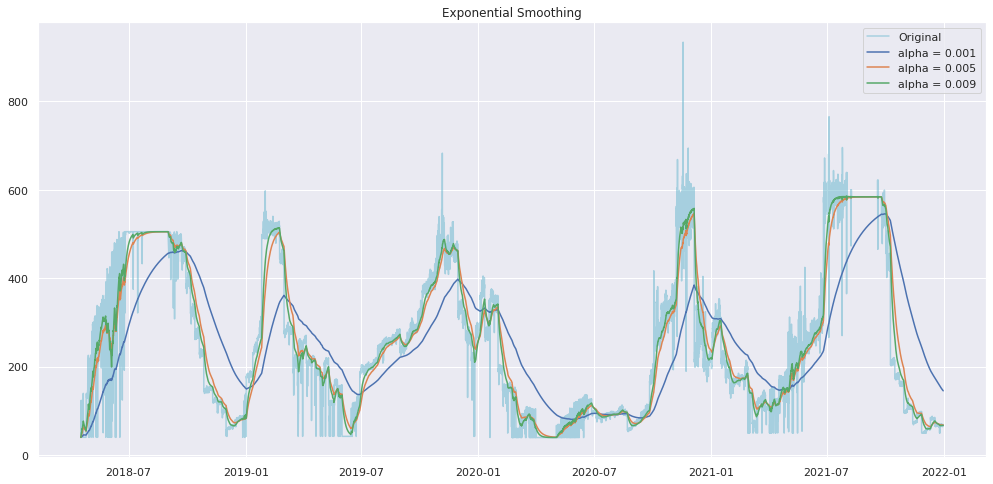

In [19]:
plot_exponential_smoothing_with_alpha(data, alphas=[0.001, 0.005, 0.009])

## Estacionariedade

De forma geral, uma série temporal é estacionária se ela se desenvolve ao longo do tempo com a mesma média, mesma variância e mesma autocovariância. Isso significa que se pegarmos um pedaço da série temporal, não importa de onde, ela terá as mesmas características.

A série **não é estacionária** se:
- Possuí tendência;
- Tem variabilidades diferentes ao longo do tempo.
    



Vários modelos de séries temporais requerem que os dados sejam estacionários. Então temos que checar se nossa série é estacionária e, caso não seja, transformá-la em estacionária

ARMA/ARIMA/SARIMA

Alguns outros modelos podem requerer que a série seja estacionária pelo menos na primeira ou segunda diferença


**Formalmente**:




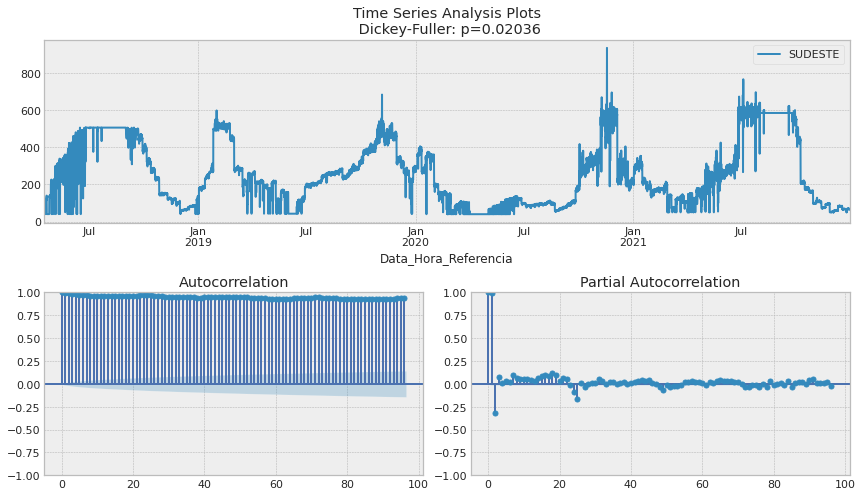

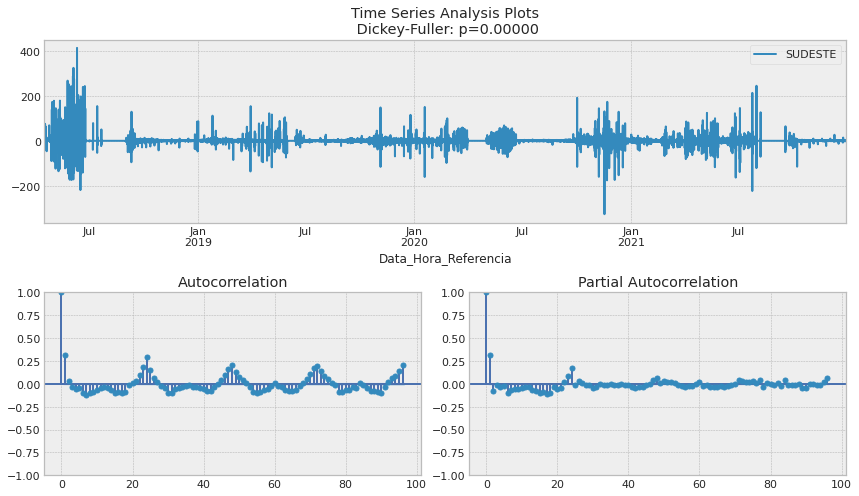

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    # if not isinstance(y, pd.Series):
        # y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data, lags=96)

# Take the first difference to remove to make the process stationary
diff_shift = 1
data_diff = data - data.shift(diff_shift)
tsplot(data_diff[diff_shift:], lags=96)

In [20]:
from statsmodels.tsa.stattools import adfuller


In [21]:
# fonte: https://machinelearningmastery.com/time-series-data-stationary-python/

result = adfuller(data, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF Statistic: -3.193508
p-value: 0.020364
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [6]:
data.head(25)

,NORDESTE,NORTE,SUDESTE,SUL
Data_Hora_Referencia,,,,
2018-04-17 00:00:00,40.160,40.160,40.160,40.160
2018-04-17 01:00:00,40.160,40.160,40.160,40.160
2018-04-17 02:00:00,40.160,40.160,40.160,40.160
2018-04-17 03:00:00,40.160,40.160,40.160,40.160
2018-04-17 04:00:00,40.160,40.160,40.160,40.160
2018-04-17 05:00:00,40.160,40.160,40.160,40.160
2018-04-17 06:00:00,40.160,40.160,40.160,40.160
2018-04-17 07:00:00,40.160,40.160,40.160,40.160
2018-04-17 08:00:00,116.880,116.840,116.860,116.860


In [11]:
media_diaria = data.resample('D').mean()

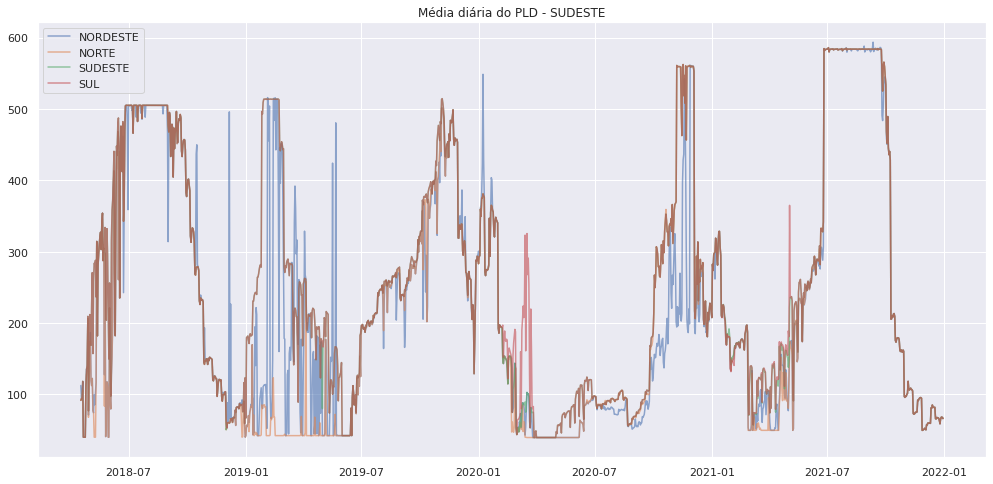

In [24]:
plt.figure(figsize=(17, 8))

submercado = 'NORTE'
submercado = 'NORDESTE'
submercado = 'SUL'
submercado = 'SUDESTE'

plt.plot(media_diaria, label=media_diaria.columns, alpha=0.6)
plt.legend(loc="best")
plt.axis('tight')
plt.title(f'Média diária do PLD - {submercado}')
plt.grid(True);

<AxesSubplot:>

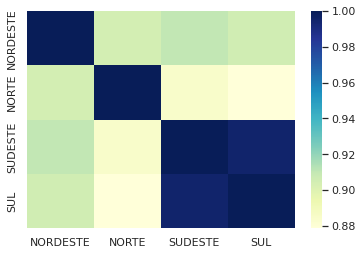

In [40]:
corr = media_diaria.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="YlGnBu",
            # vmin=0,
            # vmax=1,
            )

,NORDESTE,NORTE,SUDESTE,SUL
NORDESTE,1.00,0.90,0.91,0.91
NORTE,0.90,1.00,0.88,0.88
SUDESTE,0.91,0.88,1.00,0.99
SUL,0.91,0.88,0.99,1.00
